In [2]:
import mediapipe as mp
import cv2
import tensorflow
print("MediaPipe version:", mp.__version__)
print("OpenCV version:", cv2.__version__)
print("Tensorflow version:", tensorflow.__version__)




MediaPipe version: 0.10.21
OpenCV version: 4.11.0
Tensorflow version: 2.15.0



<span style="font-family: 'Times New Roman'; font-size: 35px;"><b>Preprocessing and extraction</b></span>
<br>
<span style="font-family: 'Times New Roman'; font-size: 20px;">first trial</span>



In [6]:
import os
import csv
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import ffmpeg
from tqdm import tqdm # For visualizing progress
from sklearn.preprocessing import MinMaxScaler
import time
import sys

# --- 1. CONFIGURATION ---
# Define the root directory for your raw data
data_root_dir = "data"

# Define the desired standard video format
standard_fps = 30
standard_resolution = "640:480" # Width:Height
# REAL FOLDERS NAMES IN OUR DATASET:test_rgb_front_clips,val_rgb_front_clips,train_rgb_front_clips
# List of folders and their corresponding CSV file names
csv_files_info = {
    "training": "how2sign_realigned_train.csv",
    "testing": "how2sign_realigned_test.csv",
    "validation": "how2sign_realigned_val.csv"
}

# The subfolder containing the raw videos
raw_videos_subfolder = "raw_videos"

# Output directory for the final processed NumPy arrays and CSVs
OUTPUT_DATA_DIR = 'processed_gru_data'
os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

# Define Hyperparameters for the GRU Model Input
SEQUENCE_LENGTH = 60

# Initialize MediaPipe Holistic for extracting all landmarks (hands, face, pose)
mp_holistic = mp.solutions.holistic

# --- 2. HELPER FUNCTIONS ---

def extract_landmarks(results):
    """
    Extracts and flattens all available MediaPipe landmarks into a single 1D array.
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
        if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() \
        if results.face_landmarks else np.zeros(468*4)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() \
        if results.left_hand_landmarks else np.zeros(21*4)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() \
        if results.right_hand_landmarks else np.zeros(21*4)
    return np.concatenate([pose, face, lh, rh])

def process_and_extract_sequence(video_path, holistic_model):
    """
    Reads a video and extracts the sequence of landmark features.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None
    frame_sequence = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic_model.process(image_rgb)
        keypoints = extract_landmarks(results)
        frame_sequence.append(keypoints)
    cap.release()
    return np.array(frame_sequence)

def normalize_and_pad_sequence(sequence, scaler, max_length=SEQUENCE_LENGTH):
    """Normalizes coordinates and pads/truncates the sequence to a fixed length."""
    if sequence.size == 0:
        return np.zeros((max_length, scaler.n_features_in_))
    normalized_sequence = scaler.transform(sequence)
    if normalized_sequence.shape[0] < max_length:
        padding_needed = max_length - normalized_sequence.shape[0]
        padding = np.zeros((padding_needed, normalized_sequence.shape[1]))
        padded_sequence = np.concatenate([normalized_sequence, padding], axis=0)
    elif normalized_sequence.shape[0] > max_length:
        padded_sequence = normalized_sequence[:max_length, :]
    else:
        padded_sequence = normalized_sequence
    return padded_sequence
    
# --- 3. MAIN EXECUTION ---
def main():
    
    # --- Phase 1: Preprocessing and Aligning Raw Data ---
    print("--- Phase 1: Preprocessing and Aligning Raw Data ---")
    
    all_video_data_from_processed_dirs = []
    
    for folder_name, csv_file_name in csv_files_info.items():
        input_videos_dir = os.path.join(data_root_dir, folder_name, raw_videos_subfolder)
        input_csv_path = os.path.join(data_root_dir, folder_name, csv_file_name)
        
        processed_videos_dir = os.path.join(data_root_dir, f"processed_{folder_name}", "videos")
        processed_csv_dir = os.path.join(data_root_dir, f"processed_{folder_name}")
        os.makedirs(processed_videos_dir, exist_ok=True)
        os.makedirs(processed_csv_dir, exist_ok=True)

        print(f"Aligning and processing '{folder_name}'...")
        
        if not os.path.exists(input_videos_dir) or not os.path.exists(input_csv_path):
            print(f"Warning: Raw data not found for '{folder_name}'. Skipping.")
            continue

        df_raw = pd.read_csv(input_csv_path, sep='\t')
        
        processed_rows = []
        video_id_counter = 0

        raw_video_files = [f for f in os.listdir(input_videos_dir) if f.endswith((".mp4", ".mov", ".avi", ".mkv"))]
        raw_video_names_without_ext = {os.path.splitext(f)[0] for f in raw_video_files}
        
        df_aligned = df_raw[df_raw['SENTENCE_NAME'].isin(raw_video_names_without_ext)].copy()

        for index, row in tqdm(df_aligned.iterrows(), total=len(df_aligned), desc=f" {folder_name} videos"):
            video_name = row['SENTENCE_NAME']
            label = row['SENTENCE']
            
            video_file_with_ext = next((f for f in raw_video_files if os.path.splitext(f)[0] == video_name), None)
            if video_file_with_ext is None:
                continue
                
            input_video_path = os.path.join(input_videos_dir, video_file_with_ext)
            output_video_path = os.path.join(processed_videos_dir, f"{video_name}.mp4")

            try:
                (
                    ffmpeg
                    .input(input_video_path)
                    .output(output_video_path, vf=f"fps={standard_fps},scale={standard_resolution}", vcodec="libx264", crf=20)
                    .run(overwrite_output=True, quiet=True)
                )
                
                processed_row = {
                    'video_id': video_id_counter,
                    'SENTENCE_NAME': video_name,
                    'SENTENCE': label
                }
                processed_rows.append(processed_row)
                video_id_counter += 1

            except ffmpeg.Error:
                print(f"Warning: FFmpeg standardization failed for {video_name}. Skipping.")
                continue

        processed_df = pd.DataFrame(processed_rows)
        processed_df.to_csv(os.path.join(processed_csv_dir, f"processed_{folder_name}.csv"), sep='\t', index=False)
        print(f"Saved processed CSV for {folder_name} with {len(processed_rows)} aligned rows.")
        
        for row in processed_rows:
            video_path = os.path.join(processed_videos_dir, row['SENTENCE_NAME'] + '.mp4')
            all_video_data_from_processed_dirs.append((video_path, row['SENTENCE'], folder_name))

    print("\nAll preprocessing and alignment complete.")
    print(f"Total videos found after preprocessing: {len(all_video_data_from_processed_dirs)}")
    
    # --- Phase 2: First Pass - Extract & fit scaler on training data ---
    print("\n--- Phase 2: Fitting Normalizer on training data ---")
    training_data_raw = []
    training_data = [item for item in all_video_data_from_processed_dirs if item[2] == 'training']

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for video_path, _, _ in tqdm(training_data, desc="Extracting Raw Training Keypoints"):
            raw_sequence = process_and_extract_sequence(video_path, holistic)
            if raw_sequence is not None and raw_sequence.size > 0:
                training_data_raw.append(raw_sequence)

    if not training_data_raw:
        print("No training data found. Cannot fit scaler. Exiting.")
        return
    
    combined_train_frames = np.vstack(training_data_raw)
    scaler = MinMaxScaler()
    scaler.fit(combined_train_frames)
    print(f"Normalizer (MinMaxScaler) fitted on {combined_train_frames.shape[0]} training frames.")

    # --- Phase 3: Second Pass - Process, Normalize, and Save ---
    print("\n--- Phase 3: Normalizing, Padding, and Saving Sequences ---")
    final_data = {'training': {'X': [], 'y': []}, 
                  'testing': {'X': [], 'y': []}, 
                  'validation': {'X': [], 'y': []}}
    unique_labels = sorted(list(set(item[1] for item in all_video_data_from_processed_dirs)))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for video_path, label, folder_type in tqdm(all_video_data_from_processed_dirs, desc="Final Processing and Saving"):
            raw_sequence = process_and_extract_sequence(video_path, holistic)
            if raw_sequence is None or raw_sequence.size == 0:
                continue
            padded_sequence = normalize_and_pad_sequence(raw_sequence, scaler)
            int_label = label_to_int[label]
            final_data[folder_type]['X'].append(padded_sequence)
            final_data[folder_type]['y'].append(int_label)
    
    for set_key, data in final_data.items():
        if data['X']:
            X_data = np.array(data['X'])
            y_data = np.array(data['y'])
            np.save(os.path.join(OUTPUT_DATA_DIR, f'X_{set_key}.npy'), X_data)
            np.save(os.path.join(OUTPUT_DATA_DIR, f'y_{set_key}.npy'), y_data)
            print(f"\nSaved {set_key} data: X_shape={X_data.shape}, y_shape={y_data.shape}")

    label_df = pd.DataFrame(list(label_to_int.items()), columns=['SENTENCE', 'LABEL_INT'])
    label_df.to_csv(os.path.join(OUTPUT_DATA_DIR, 'label_map.csv'), index=False)
    print(f"\nLabel map saved with {len(unique_labels)} unique sentences.")
    
if __name__ == '__main__':
    main()

--- Phase 1: Preprocessing and Aligning Raw Data ---
Aligning and processing 'training'...


Standardizing training videos: 100%|█████████████████████████████████████████████████| 182/182 [01:12<00:00,  2.52it/s]


Saved processed CSV for training with 182 aligned rows.
Aligning and processing 'testing'...


Standardizing testing videos: 100%|████████████████████████████████████████████████████| 84/84 [00:43<00:00,  1.93it/s]


Saved processed CSV for testing with 84 aligned rows.
Aligning and processing 'validation'...


Standardizing validation videos: 100%|█████████████████████████████████████████████████| 84/84 [00:33<00:00,  2.52it/s]


Saved processed CSV for validation with 84 aligned rows.

All preprocessing and alignment complete.
Total videos found after preprocessing: 350

--- Phase 2: Fitting Normalizer on training data ---


Extracting Raw Training Keypoints: 100%|███████████████████████████████████████████| 182/182 [1:50:55<00:00, 36.57s/it]


Normalizer (MinMaxScaler) fitted on 34215 training frames.

--- Phase 3: Normalizing, Padding, and Saving Sequences ---


Final Processing and Saving: 100%|█████████████████████████████████████████████████| 350/350 [3:30:23<00:00, 36.07s/it]



Saved training data: X_shape=(182, 60, 2172), y_shape=(182,)

Saved testing data: X_shape=(84, 60, 2172), y_shape=(84,)

Saved validation data: X_shape=(84, 60, 2172), y_shape=(84,)

Label map saved with 305 unique sentences.


In [7]:
import os
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm # For visualizing progress

# --- 1. CONFIGURATION ---
# Define the root directory where your processed data resides.
ROOT_DIR = 'data'
PROCESSED_FOLDERS = ['processed_training', 'processed_testing', 'processed_validation']
# Output directory for the final processed NumPy arrays
OUTPUT_DATA_DIR = 'processed_gru_data'
os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)
# Define Hyperparameters for the GRU Model Input
SEQUENCE_LENGTH = 60

# Initialize MediaPipe Holistic for extracting all landmarks (hands, face, pose)
mp_holistic = mp.solutions.holistic

# --- 2. HELPER FUNCTIONS ---
def extract_landmarks(results):
    """
    Extracts and flattens all available MediaPipe landmarks into a single 1D array.
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
        if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() \
        if results.face_landmarks else np.zeros(468*4)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() \
        if results.left_hand_landmarks else np.zeros(21*4)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() \
        if results.right_hand_landmarks else np.zeros(21*4)
    return np.concatenate([pose, face, lh, rh])

def process_and_extract_sequence(video_path, holistic_model):
    """Reads a video and extracts the sequence of landmark features."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None
    frame_sequence = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic_model.process(image_rgb)
        keypoints = extract_landmarks(results)
        frame_sequence.append(keypoints)
    cap.release()
    return np.array(frame_sequence)

def normalize_and_pad_sequence(sequence, scaler, max_length=SEQUENCE_LENGTH):
    """Normalizes coordinates and pads/truncates the sequence to a fixed length."""
    if sequence.size == 0:
        return np.zeros((max_length, scaler.n_features_in_))
    normalized_sequence = scaler.transform(sequence)
    if normalized_sequence.shape[0] < max_length:
        padding_needed = max_length - normalized_sequence.shape[0]
        padding = np.zeros((padding_needed, normalized_sequence.shape[1]))
        padded_sequence = np.concatenate([normalized_sequence, padding], axis=0)
    elif normalized_sequence.shape[0] > max_length:
        padded_sequence = normalized_sequence[:max_length, :]
    else:
        padded_sequence = normalized_sequence
    return padded_sequence
    
# --- 3. MAIN EXECUTION ---
def main():
    all_video_data = []
    
    # --- Phase 1: Load data from already processed folders ---
    print("--- Phase 1: Loading Processed Data ---")
    for folder in PROCESSED_FOLDERS:
        # Correctly join the path for the processed CSV
        # The filename created by the first script is 'processed_training.csv', etc.
        label_csv_path = os.path.join(ROOT_DIR, folder, f"{folder}.csv") 
        videos_dir = os.path.join(ROOT_DIR, folder, "videos")
        
        if not os.path.exists(label_csv_path) or not os.path.exists(videos_dir):
            print(f"Warning: Processed data not found for '{folder}'. Skipping.")
            continue
            
        df_labels = pd.read_csv(label_csv_path, sep='\t')
        
        for index, row in df_labels.iterrows():
            video_name = row['SENTENCE_NAME']
            label = row['SENTENCE']
            video_filepath = os.path.join(videos_dir, video_name + '.mp4')
            
            if os.path.exists(video_filepath):
                all_video_data.append((video_filepath, label, folder))
            else:
                print(f"Missing video file: {video_filepath}. Skipping.")

    if not all_video_data:
        print("No video data found. Please check your paths and file names.")
        return
    print(f"Total videos found across all sets: {len(all_video_data)}")

    # --- Phase 2: First Pass - Extract & fit scaler on training data ---
    print("\n--- Phase 2: Fitting Normalizer on training data ---")
    training_data_raw = []
    training_data = [item for item in all_video_data if 'training' in item[2]]

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for video_path, _, _ in tqdm(training_data, desc="Extracting Raw Training Keypoints"):
            raw_sequence = process_and_extract_sequence(video_path, holistic)
            if raw_sequence is not None and raw_sequence.size > 0:
                training_data_raw.append(raw_sequence)

    if not training_data_raw:
        print("No training data found for scaler fitting. Please check your files.")
        return
    
    combined_train_frames = np.vstack(training_data_raw)
    scaler = MinMaxScaler()
    scaler.fit(combined_train_frames)
    print(f"Normalizer (MinMaxScaler) fitted on {combined_train_frames.shape[0]} training frames.")

    # --- Phase 3: Second Pass - Process, Normalize, and Save ---
    print("\n--- Phase 3: Normalizing, Padding, and Saving Sequences ---")
    final_data = {'training': {'X': [], 'y': []}, 
                  'testing': {'X': [], 'y': []}, 
                  'validation': {'X': [], 'y': []}}
    unique_labels = sorted(list(set(item[1] for item in all_video_data)))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for video_path, label, folder_type in tqdm(all_video_data, desc="Final Processing and Saving"):
            raw_sequence = process_and_extract_sequence(video_path, holistic)
            if raw_sequence is None or raw_sequence.size == 0:
                continue
            padded_sequence = normalize_and_pad_sequence(raw_sequence, scaler)
            int_label = label_to_int[label]
            key = folder_type.split('_')[1]
            final_data[key]['X'].append(padded_sequence)
            final_data[key]['y'].append(int_label)
    
    for set_key, data in final_data.items():
        if data['X']:
            X_data = np.array(data['X'])
            y_data = np.array(data['y'])
            np.save(os.path.join(OUTPUT_DATA_DIR, f'X_{set_key}.npy'), X_data)
            np.save(os.path.join(OUTPUT_DATA_DIR, f'y_{set_key}.npy'), y_data)
            print(f"\nSaved {set_key} data: X_shape={X_data.shape}, y_shape={y_data.shape}")

    label_df = pd.DataFrame(list(label_to_int.items()), columns=['SENTENCE', 'LABEL_INT'])
    label_df.to_csv(os.path.join(OUTPUT_DATA_DIR, 'label_map.csv'), index=False)
    print(f"\nLabel map saved with {len(unique_labels)} unique sentences.")
    
if __name__ == '__main__':
    main()

--- Phase 1: Loading Processed Data ---
Total videos found across all sets: 350

--- Phase 2: Fitting Normalizer on training data ---


Extracting Raw Training Keypoints: 100%|███████████████████████████████████████████| 182/182 [1:43:26<00:00, 34.10s/it]


Normalizer (MinMaxScaler) fitted on 34215 training frames.

--- Phase 3: Normalizing, Padding, and Saving Sequences ---


Final Processing and Saving: 100%|█████████████████████████████████████████████████| 350/350 [3:31:11<00:00, 36.21s/it]



Saved training data: X_shape=(182, 60, 2172), y_shape=(182,)

Saved testing data: X_shape=(84, 60, 2172), y_shape=(84,)

Saved validation data: X_shape=(84, 60, 2172), y_shape=(84,)

Label map saved with 305 unique sentences.


<span style="font-family: 'Times New Roman'; font-size: 20px;">generated code for testing purposes</span>


In [8]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. CONFIGURATION ---
OUTPUT_DATA_DIR = 'processed_gru_data'

# --- 2. DATA LOADING & PREPARATION ---
print("--- Loading Data ---")

X_train = np.load(os.path.join(OUTPUT_DATA_DIR, 'X_training.npy'))
y_train = np.load(os.path.join(OUTPUT_DATA_DIR, 'y_training.npy'))
X_test = np.load(os.path.join(OUTPUT_DATA_DIR, 'X_testing.npy'))
y_test = np.load(os.path.join(OUTPUT_DATA_DIR, 'y_testing.npy'))
X_val = np.load(os.path.join(OUTPUT_DATA_DIR, 'X_validation.npy'))
y_val = np.load(os.path.join(OUTPUT_DATA_DIR, 'y_validation.npy'))

label_map_df = pd.read_csv(os.path.join(OUTPUT_DATA_DIR, 'label_map.csv'))
num_classes = len(label_map_df)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"Number of classes: {num_classes}")

y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# --- 3. BUILD AND COMPILE A SIMPLER GRU MODEL ---
print("\n--- Building and Compiling a Simpler Model ---")

num_features = X_train.shape[2]
sequence_length = X_train.shape[1]

model = Sequential()
model.add(Input(shape=(sequence_length, num_features))) 
model.add(GRU(32, return_sequences=True))  # Further reduced units
model.add(Dropout(0.7))                     # Increased dropout
model.add(GRU(16))                        # Reduced units
model.add(Dropout(0.7))                     # Increased dropout
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 4. TRAIN THE MODEL ---
print("\n--- Starting Model Training ---")

# Add EarlyStopping to monitor validation loss and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train_one_hot,
    epochs=100,
    batch_size=4,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[early_stopping] # Add the callback here
)

print("\nModel training complete.")

# --- 5. EVALUATE THE MODEL ---
print("\n--- Final Model Evaluation on Test Data ---")
loss, accuracy = model.evaluate(X_test, y_test_one_hot, verbose=0)

print(f"\nModel Accuracy on Test Data: {accuracy * 100:.2f}%")
print(f"Model Loss on Test Data: {loss:.4f}")

--- Loading Data ---
X_train shape: (182, 60, 2172)
y_train shape: (182,)
X_test shape: (84, 60, 2172)
y_test shape: (84,)
X_val shape: (84, 60, 2172)
y_val shape: (84,)
Number of classes: 305

--- Building and Compiling a Simpler Model ---


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 32)            211776    
                                                                 
 dropout (Dropout)           (None, 60, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 32)                544       
           

<span style="font-family: 'Times New Roman'; font-size: 35px;"><b>Preprocessing and extraction</b></span>
<br>
<span style="font-family: 'Times New Roman'; font-size: 20px;">second trial</span>



In [38]:
import os
import csv
import numpy as np
import pandas as pd
import cv2
import ffmpeg
from tqdm import tqdm
import time
import sys

# --- CONFIGURATION ---
data_root_dir = "data"
standard_fps = 30
standard_resolution = "640:480"
# REAL FOLDERS NAMES IN OUR DATASET:test_rgb_front_clips,val_rgb_front_clips,train_rgb_front_clips
csv_files_info = {
    "training": "how2sign_realigned_train.csv",
    "testing": "how2sign_realigned_test.csv",
    "validation": "how2sign_realigned_val.csv"
}
raw_videos_subfolder = "raw_videos"

# --- HELPER FUNCTION ---
def verify_video_properties(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return fps, (width, height)


# --- PHASE 1: PREPROCESSING & ALIGNMENT ---
print("--- Phase 1: Preprocessing and Aligning Raw Data ---")

all_video_data_from_processed_dirs = []

for folder_name, csv_file_name in csv_files_info.items():
    input_videos_dir = os.path.join(data_root_dir, folder_name, raw_videos_subfolder)
    input_csv_path = os.path.join(data_root_dir, folder_name, csv_file_name)

    processed_videos_dir = os.path.join(data_root_dir, f"processed_{folder_name}", "videos")
    processed_csv_dir = os.path.join(data_root_dir, f"processed_{folder_name}")
    os.makedirs(processed_videos_dir, exist_ok=True)
    os.makedirs(processed_csv_dir, exist_ok=True)

    print(f"Aligning and processing '{folder_name}'...")

    if not os.path.exists(input_videos_dir) or not os.path.exists(input_csv_path):
        print(f"Warning: Raw data not found for '{folder_name}'. Skipping.")
        continue

    df_raw = pd.read_csv(input_csv_path, sep='\t')

    processed_rows = []
    video_id_counter = 0

    raw_video_files = [f for f in os.listdir(input_videos_dir) if f.endswith((".mp4", ".mov", ".avi", ".mkv"))]
    raw_video_names_without_ext = {os.path.splitext(f)[0] for f in raw_video_files}

    df_aligned = df_raw[df_raw['SENTENCE_NAME'].isin(raw_video_names_without_ext)].copy()

    for index, row in tqdm(df_aligned.iterrows(), total=len(df_aligned), desc=f"+ {folder_name} videos"):
        video_name = row['SENTENCE_NAME']
        label = row['SENTENCE']

        video_file_with_ext = next((f for f in raw_video_files if os.path.splitext(f)[0] == video_name), None)
        if video_file_with_ext is None:
            continue

        input_video_path = os.path.join(input_videos_dir, video_file_with_ext)
        output_video_path = os.path.join(processed_videos_dir, f"{video_name}.mp4")

        # Skip already processed
        if os.path.exists(output_video_path):
            print(f"[SKIP] {output_video_path} already exists.")
        else:
            try:
                (
                    ffmpeg
                    .input(input_video_path)
                    .output(output_video_path, vf=f"fps={standard_fps},scale={standard_resolution}",
                            vcodec="libx264", crf=20)
                    .run(overwrite_output=True, quiet=True)
                )
            except ffmpeg.Error:
                print(f"Warning: FFmpeg failed for {video_name}.")
                continue

        props = verify_video_properties(output_video_path)
        if props:
            fps, (w, h) = props
            if abs(fps - standard_fps) > 1 or (w, h) != tuple(map(int, standard_resolution.split(":"))):
                print(f"[WARNING] {video_name}: Non-standard ({fps:.1f} fps, {w}x{h})")

        processed_row = {
            'video_id': video_id_counter,
            'SENTENCE_NAME': f"{video_name}",
            'SENTENCE': label
        }
        processed_rows.append(processed_row)
        video_id_counter += 1

    processed_df = pd.DataFrame(processed_rows)
    processed_df.to_csv(os.path.join(processed_csv_dir, f"processed_{folder_name}.csv"), sep='\t', index=False)
    print(f" Saved processed CSV for {folder_name} with {len(processed_rows)} aligned rows.")

    for row in processed_rows:
        video_path = os.path.join(processed_videos_dir, row['SENTENCE_NAME'] + '.mp4')
        all_video_data_from_processed_dirs.append((video_path, row['SENTENCE'], folder_name))

print("\n All preprocessing and alignment complete.")
print(f"Total videos found after preprocessing: {len(all_video_data_from_processed_dirs)}")

# Save video list for next cell
import joblib
joblib.dump(all_video_data_from_processed_dirs, "all_video_data.pkl")
print("Saved video metadata list as 'all_video_data.pkl' for next phase.")


--- Phase 1: Preprocessing and Aligning Raw Data ---
Aligning and processing 'training'...


+ training videos: 100%|█████████████████████████████████████████████████████████████| 196/196 [01:40<00:00,  1.96it/s]


 Saved processed CSV for training with 196 aligned rows.
Aligning and processing 'testing'...


+ testing videos: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:46<00:00,  2.09it/s]


 Saved processed CSV for testing with 98 aligned rows.
Aligning and processing 'validation'...


+ validation videos: 100%|█████████████████████████████████████████████████████████████| 84/84 [00:42<00:00,  1.99it/s]

 Saved processed CSV for validation with 84 aligned rows.

 All preprocessing and alignment complete.
Total videos found after preprocessing: 378
Saved video metadata list as 'all_video_data.pkl' for next phase.


In [39]:
import numpy as np
import cv2
import mediapipe as mp
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
import os
import pandas as pd

# --- CONFIGURATION ---
OUTPUT_DATA_DIR = 'processed_gru_data'
SEQUENCE_LENGTH = 60
mp_holistic = mp.solutions.holistic

# --- LOAD VIDEO LIST ---
all_video_data_from_processed_dirs = load("all_video_data.pkl")

# --- HELPER FUNCTIONS ---
def extract_landmarks(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
        if results.pose_landmarks else np.zeros(33 * 4)
    face = np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() \
        if results.face_landmarks else np.zeros(468 * 4)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() \
        if results.left_hand_landmarks else np.zeros(21 * 4)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() \
        if results.right_hand_landmarks else np.zeros(21 * 4)
    return np.concatenate([pose, face, lh, rh])


def process_and_extract_sequence(video_path, holistic_model):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    frame_sequence = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic_model.process(image_rgb)
        keypoints = extract_landmarks(results)
        frame_sequence.append(keypoints)
    cap.release()
    return np.array(frame_sequence) if frame_sequence else None


def normalize_and_pad_sequence(sequence, scaler, max_length=SEQUENCE_LENGTH):
    if sequence.size == 0:
        return np.zeros((max_length, scaler.n_features_in_))
    normalized_sequence = scaler.transform(sequence)
    if normalized_sequence.shape[0] < max_length:
        padding = np.zeros((max_length - normalized_sequence.shape[0], normalized_sequence.shape[1]))
        return np.concatenate([normalized_sequence, padding], axis=0)
    else:
        return normalized_sequence[:max_length, :]


# --- PHASE 2: LANDMARK EXTRACTION ---
print("\n--- Phase 2: Landmark Extraction & Normalization ---")

training_data = [v for v in all_video_data_from_processed_dirs if v[2] == 'training']
final_data = {'training': {'X': [], 'y': []},
              'testing': {'X': [], 'y': []},
              'validation': {'X': [], 'y': []}}

# Extract training data for fitting scaler
training_data_raw = []
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for video_path, _, _ in tqdm(training_data, desc="Extracting training landmarks"):
        seq = process_and_extract_sequence(video_path, holistic)
        if seq is not None and seq.size > 0:
            training_data_raw.append(seq)

if not training_data_raw:
    raise ValueError("No training sequences found. Check your video paths.")

combined_train_frames = np.vstack(training_data_raw)
scaler = MinMaxScaler().fit(combined_train_frames)
dump(scaler, os.path.join(OUTPUT_DATA_DIR, 'scaler.pkl'))
print(f" Scaler fitted and saved with {combined_train_frames.shape[0]} frames.")

# Build label map
unique_labels = sorted(set(label for _, label, _ in all_video_data_from_processed_dirs))
label_to_int = {label: i for i, label in enumerate(unique_labels)}

# --- Normalize, pad, and save all sets ---
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for video_path, label, folder_type in tqdm(all_video_data_from_processed_dirs, desc="Processing all videos"):
        seq = process_and_extract_sequence(video_path, holistic)
        if seq is None or seq.size == 0:
            continue
        seq_norm = normalize_and_pad_sequence(seq, scaler)
        final_data[folder_type]['X'].append(seq_norm)
        final_data[folder_type]['y'].append(label_to_int[label])

for set_key, data in final_data.items():
    if data['X']:
        X, y = np.array(data['X']), np.array(data['y'])
        np.save(os.path.join(OUTPUT_DATA_DIR, f'X_{set_key}.npy'), X)
        np.save(os.path.join(OUTPUT_DATA_DIR, f'y_{set_key}.npy'), y)
        print(f" Saved {set_key}: X={X.shape}, y={y.shape}")

pd.DataFrame(label_to_int.items(), columns=['SENTENCE', 'LABEL_INT']).to_csv(
    os.path.join(OUTPUT_DATA_DIR, 'label_map.csv'), index=False
)
print("\n Landmark extraction, normalization, and saving complete.")



--- Phase 2: Landmark Extraction & Normalization ---


Extracting training landmarks: 100%|███████████████████████████████████████████████| 196/196 [1:23:11<00:00, 25.47s/it]


 Scaler fitted and saved with 36229 frames.


Processing all videos: 100%|███████████████████████████████████████████████████████| 378/378 [3:06:06<00:00, 29.54s/it]


 Saved training: X=(196, 60, 2172), y=(196,)
 Saved testing: X=(98, 60, 2172), y=(98,)
 Saved validation: X=(84, 60, 2172), y=(84,)

 Landmark extraction, normalization, and saving complete.


<span style="font-family: 'Times New Roman'; font-size: 20px;">generated code for testing purposes</span>


 Checking processed outputs...

✅ processed_gru_data\scaler.pkl
✅ processed_gru_data\X_training.npy
✅ processed_gru_data\y_training.npy
✅ processed_gru_data\label_map.csv
✅ all_video_data.pkl

 Total videos in metadata: 378
 Scaler features: 2172

 Label map:
                                            SENTENCE  LABEL_INT
0  A bladder infection is diagnosed at your veter...          0
1                                 A face of a woman.          1
2  A great variation of the hurricane, is the hur...          2
3  Again if you're not sure, test the wax on the ...          3
4  Again, for oily skin you can go four to seven ...          4

 Sample video: -_3bUhnn4PU_0-8-rgb_front.mp4
 Label: Hi, today, we're going to draw on coquille board.


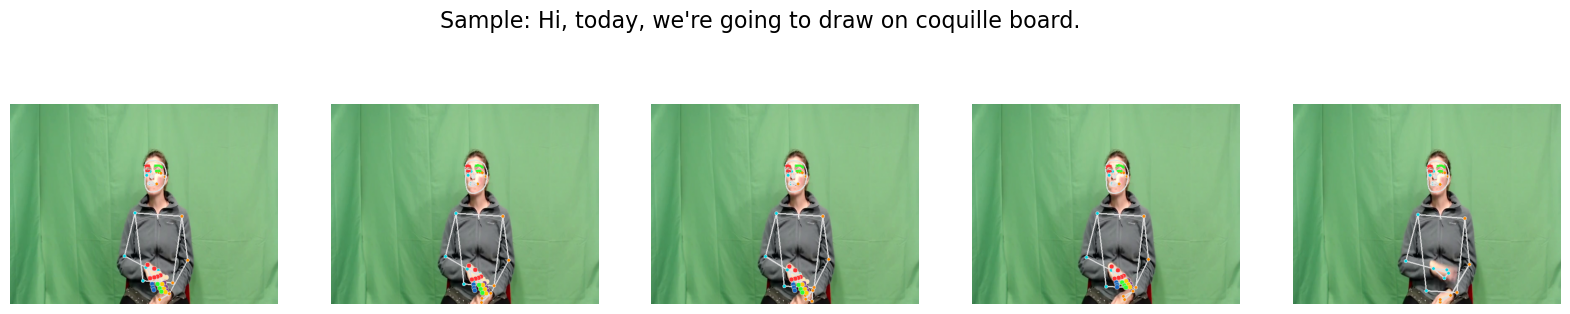

In [40]:
import os
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from joblib import load

# --- CONFIGURATION ---
OUTPUT_DATA_DIR = 'processed_gru_data'
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

# --- STEP 1: Verify data files ---
print(" Checking processed outputs...\n")

expected_files = [
    os.path.join(OUTPUT_DATA_DIR, 'scaler.pkl'),
    os.path.join(OUTPUT_DATA_DIR, 'X_training.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'y_training.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'label_map.csv'),
    "all_video_data.pkl"
]

for f in expected_files:
    print(f"{'✅' if os.path.exists(f) else '❌'} {f}")

# --- STEP 2: Load data and scaler ---
from sklearn.preprocessing import MinMaxScaler

scaler = load(os.path.join(OUTPUT_DATA_DIR, 'scaler.pkl'))
label_map = pd.read_csv(os.path.join(OUTPUT_DATA_DIR, 'label_map.csv'))
video_data = load("all_video_data.pkl")

print(f"\n Total videos in metadata: {len(video_data)}")
print(f" Scaler features: {scaler.n_features_in_}")
print("\n Label map:")
print(label_map.head())

# --- STEP 3: Select one sample video to visualize ---
sample_video_path = None
for v_path, label, folder in video_data:
    if os.path.exists(v_path):
        sample_video_path = v_path
        sample_label = label
        break

if sample_video_path is None:
    raise FileNotFoundError(" No valid video found in 'all_video_data.pkl'.")

print(f"\n Sample video: {os.path.basename(sample_video_path)}")
print(f" Label: {sample_label}")

# --- STEP 4: Visualize landmarks on a few frames ---
cap = cv2.VideoCapture(sample_video_path)
frames_to_show = []
frame_count = 0

with mp_holistic.Holistic(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as holistic:

    while cap.isOpened() and len(frames_to_show) < 5:  # show 5 frames max
        ret, frame = cap.read()
        if not ret:
            break

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(image_rgb)

        if results.pose_landmarks or results.face_landmarks or results.left_hand_landmarks or results.right_hand_landmarks:
            annotated = frame.copy()
            mp_drawing.draw_landmarks(
                annotated,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
            )
            mp_drawing.draw_landmarks(
                annotated,
                results.face_landmarks,
                mp_holistic.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_styles.get_default_face_mesh_contours_style()
            )
            mp_drawing.draw_landmarks(
                annotated,
                results.left_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_styles.get_default_hand_landmarks_style()
            )
            mp_drawing.draw_landmarks(
                annotated,
                results.right_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_styles.get_default_hand_landmarks_style()
            )

            frames_to_show.append(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        frame_count += 1

cap.release()

# --- STEP 5: Display the sample frames ---
if frames_to_show:
    fig, axs = plt.subplots(1, len(frames_to_show), figsize=(20, 4))
    for i, img in enumerate(frames_to_show):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.suptitle(f"Sample: {sample_label}", fontsize=16)
    plt.show()
else:
    print(" No landmarks detected in this sample video.")


In [41]:
import numpy as np
import pandas as pd

y = np.load("processed_gru_data/y_training.npy", allow_pickle=True)
label_map = pd.read_csv("processed_gru_data/label_map.csv")

unique, counts = np.unique(y, return_counts=True)
label_distribution = pd.DataFrame({"LabelID": unique, "Count": counts})

# Merge with actual sentence names if available
label_distribution = label_distribution.merge(label_map, left_on="LabelID", right_index=True, how="left")

print(" Label distribution (samples per class):")
print(label_distribution.sort_values(by="Count").head(20))  # Show smallest ones

print("\n Summary:")
print("Total samples:", len(y))
print("Unique labels:", len(unique))
print("Min samples per class:", counts.min())
print("Max samples per class:", counts.max())


 Label distribution (samples per class):
     LabelID  Count                                           SENTENCE  \
0          1      1                                 A face of a woman.   
123      143      1  So, those are the supplies we're going to use ...   
124      144      1  So, we're good on radiator fluid, checking you...   
125      146      1  Sometimes in a business setting or a personal ...   
126      147      1  Sometimes, maybe in class or at work, or when ...   
127      148      1  Start by dipping your stick in and if the wax,...   
128      149      1  Take your hand, hold the 2 balls against the r...   
129      150      1  That enzyme that people respond to as an aller...   
130      151      1      That's the thickness that you're looking for.   
131      152      1    That's too hot, you don't put that on the face.   
122      142      1  So, like I was saying in the last class, the e...   
132      153      1  The 8 ball will fall down, cue ball hits the 8... 

In [49]:
import os
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# CONFIG
OUTPUT_DATA_DIR = "processed_gru_data"
DESIRED_TEST_FRACTION = 0.2
RANDOM_STATE = 42

# --- 0. Verify files & try to find all_video_data.pkl if missing in folder ---
expected_files = [
    os.path.join(OUTPUT_DATA_DIR, 'scaler.pkl'),
    os.path.join(OUTPUT_DATA_DIR, 'X_training.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'y_training.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'X_testing.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'y_testing.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'X_validation.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'y_validation.npy'),
    os.path.join(OUTPUT_DATA_DIR, 'label_map.csv'),
]

print("🔍 Checking processed outputs...\n")
for p in expected_files:
    print(f"✅ Found: {os.path.basename(p)}" if os.path.exists(p) else f"❌ Missing: {os.path.basename(p)}")

# attempt to locate all_video_data.pkl upward if missing
all_video_pkl = os.path.join(OUTPUT_DATA_DIR, 'all_video_data.pkl')
if not os.path.exists(all_video_pkl):
    found = None
    max_up = 6
    cwd = os.getcwd()
    for i in range(max_up):
        dir_try = os.path.abspath(os.path.join(cwd, *(['..'] * i)))
        candidate = os.path.join(dir_try, 'all_video_data.pkl')
        if os.path.exists(candidate):
            found = candidate
            break
    if found:
        print(f"\nℹ️ Found all_video_data.pkl at: {found}")
        all_video_pkl = found
    else:
        print("\n⚠️ all_video_data.pkl not found in processed_gru_data or upward parents. Continuing without it.")
else:
    print("\nℹ️ all_video_data.pkl found in processed_gru_data.")

# --- 1. Load processed arrays ---
print("\n📦 Loading processed data from:", OUTPUT_DATA_DIR)
X_train = np.load(os.path.join(OUTPUT_DATA_DIR, "X_training.npy"))
y_train = np.load(os.path.join(OUTPUT_DATA_DIR, "y_training.npy"))
X_test  = np.load(os.path.join(OUTPUT_DATA_DIR, "X_testing.npy"))
y_test  = np.load(os.path.join(OUTPUT_DATA_DIR, "y_testing.npy"))
X_val   = np.load(os.path.join(OUTPUT_DATA_DIR, "X_validation.npy"))
y_val   = np.load(os.path.join(OUTPUT_DATA_DIR, "y_validation.npy"))
label_map_df = pd.read_csv(os.path.join(OUTPUT_DATA_DIR, "label_map.csv"))

print(f"\nShapes -> train: {X_train.shape}, test: {X_test.shape}, val: {X_val.shape}")
print(f"Unique labels -> train: {len(np.unique(y_train))}, test: {len(np.unique(y_test))}, val: {len(np.unique(y_val))}")

# optional: load all_video_data if available (not necessary for training)
if os.path.exists(all_video_pkl):
    try:
        all_video_data = joblib.load(all_video_pkl)
        print(f"Loaded all_video_data (len={len(all_video_data)})")
    except Exception as e:
        print("Warning: could not load all_video_data.pkl:", e)

# --- 2. Merge datasets for a single shuffled split (safer for your dataset) ---
X_all = np.concatenate([X_train, X_test, X_val], axis=0)
y_all = np.concatenate([y_train, y_test, y_val], axis=0)

unique_labels = np.unique(y_all)
n_classes = len(unique_labels)
print(f"\n🧩 Using total dataset: {X_all.shape[0]} samples, {n_classes} unique labels")

# encode labels to 0..n-1 (they may already be such, but enforce)
label_to_idx = {lab: idx for idx, lab in enumerate(unique_labels)}
y_encoded = np.array([label_to_idx[l] for l in y_all], dtype=int)

# convert to categorical for Keras
y_cat = to_categorical(y_encoded, num_classes=n_classes)

# --- 3. Safe split: stratify only where possible ---
from sklearn.model_selection import train_test_split

# compute counts per encoded label
counts = np.bincount(y_encoded, minlength=n_classes)
multi_labels = np.where(counts >= 2)[0]   # labels with >=2 samples
single_labels = np.where(counts == 1)[0]  # labels with exactly 1

print(f"\nLabel counts summary: labels>=2: {len(multi_labels)}, labels==1: {len(single_labels)}")

indices = np.arange(len(y_encoded))
multi_mask = np.isin(y_encoded, multi_labels)
single_mask = ~multi_mask

indices_multi = indices[multi_mask]
indices_single = indices[single_mask]

if len(indices_multi) > 0:
    print(f"Stratified splitting on {len(indices_multi)} samples (multi-sample classes). "
          f"Single-sample classes ({len(indices_single)}) → train only.")

    X_multi = X_all[indices_multi]
    y_multi_cat = y_cat[indices_multi]
    y_multi_enc = y_encoded[indices_multi]

    # ✅ dynamically adjust test size
    n_classes_multi = len(np.unique(y_multi_enc))
    total_multi = len(y_multi_enc)
    desired_test_size = max(DESIRED_TEST_FRACTION, n_classes_multi / total_multi)
    desired_test_size = min(desired_test_size, 0.5)  # avoid too large test set

    print(f"Auto-adjusted test fraction: {desired_test_size:.3f} "
          f"({int(desired_test_size * total_multi)} samples for {n_classes_multi} classes)")

    X_m_tr, X_m_te, y_m_tr_cat, y_m_te_cat, y_m_tr_enc, y_m_te_enc = train_test_split(
        X_multi, y_multi_cat, y_multi_enc,
        test_size=desired_test_size,
        random_state=RANDOM_STATE,
        stratify=y_multi_enc
    )

    # Combine multi-train with all single-sample data (singletons → train only)
    X_train_small = np.concatenate([X_m_tr, X_all[indices_single]], axis=0) if len(indices_single) > 0 else X_m_tr
    y_train_small_cat = np.concatenate([y_m_tr_cat, y_cat[indices_single]], axis=0) if len(indices_single) > 0 else y_m_tr_cat

    # Test set is just the multi-test split
    X_test_small = X_m_te
    y_test_small_cat = y_m_te_cat

else:
    # fallback: no stratified groups
    print("⚠️ No classes with ≥2 samples found. Falling back to random split (no stratify).")
    X_train_small, X_test_small, y_train_small_cat, y_test_small_cat = train_test_split(
        X_all, y_cat, test_size=DESIRED_TEST_FRACTION, random_state=RANDOM_STATE, shuffle=True
    )

print(f"\nFinal split sizes → train: {X_train_small.shape}, test: {X_test_small.shape}")

if X_test_small.shape[0] == 0:
    raise SystemExit("❌ Empty test set — aborting. Collect more data or adjust strategy.")


# --- 4. Build and train a small GRU model (output dim = number of classes) ---
n_output_classes = n_classes
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train_small.shape[1], X_train_small.shape[2])),
    GRU(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(n_output_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

print("\n🚀 Training (small test run)...")
model.fit(X_train_small, y_train_small_cat, validation_split=0.2, epochs=8, batch_size=8, verbose=1)

# --- 5. Evaluate ---
print("\n📊 Evaluating on test set...")
test_loss, test_acc = model.evaluate(X_test_small, y_test_small_cat, verbose=0)
print(f"✅ Test accuracy (on filtered test set): {test_acc:.4f}")


🔍 Checking processed outputs...

✅ Found: scaler.pkl
✅ Found: X_training.npy
✅ Found: y_training.npy
✅ Found: X_testing.npy
✅ Found: y_testing.npy
✅ Found: X_validation.npy
✅ Found: y_validation.npy
✅ Found: label_map.csv

ℹ️ Found all_video_data.pkl at: E:\Grad_Proj\all_video_data.pkl

📦 Loading processed data from: processed_gru_data

Shapes -> train: (196, 60, 2172), test: (98, 60, 2172), val: (84, 60, 2172)
Unique labels -> train: 194, test: 98, val: 84
Loaded all_video_data (len=378)

🧩 Using total dataset: 378 samples, 222 unique labels

Label counts summary: labels>=2: 100, labels==1: 122
Stratified splitting on 256 samples (multi-sample classes). Single-sample classes (122) → train only.
Auto-adjusted test fraction: 0.391 (100 samples for 100 classes)

Final split sizes → train: (278, 60, 2172), test: (100, 60, 2172)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_